# Evaluations of different model over the prerpocessed data

In [30]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.decomposition as decomposition
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
import os
import seaborn as sns
import pandas as pd
from custom_print import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.pipeline import make_pipeline

In [31]:
def log_regression(x,y):
    print_configs("Model: Logistic Regression")
    model = LogisticRegression(random_state=0).fit(x, y)
    return model

def svr_regression(x,y):
    print_configs("Model: SVR")
    model = LinearSVR(C=1.0, epsilon=0.2).fit(x, y)
    return model
    
def lin_regr(x, y):
    print_configs("Model: Linear Regression")
    model = LinearRegression().fit(x, y)
    return model

def grad_boost(x, y):
    print_configs("Model: Gradient Boosting")
    model = GradientBoostingRegressor(random_state=0).fit(x, y)

    return model

In [32]:
def scale(x,y):
    scaler_x = preprocessing.RobustScaler()
    scaler_y = preprocessing.RobustScaler()
    x = scaler_x.fit_transform(x)
    y = y.ravel()
    return x, y, scaler_y

def evaluations(x,y, f, desc = None):
    
    if desc is not None:
        print_info(desc)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)    
    
    model = f(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print_info(f"Model score: {train_score}")
    model_prediction = model.predict(X_test)
    accuracy_score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, model_prediction)
    r2 = r2_score(y_test, model_prediction)
    print_info("Metrics are:\n Accuracy: {}\n MSE: {} \n R2: {}\n\n".format(accuracy_score, mse, r2))
    
    print_info("Predictions:")
    for i in range(len(y_test)//50):
        print("y_test[{}]: {}, model_prediction[{}]: {}".format(i, y_test[i], i, model_prediction[i]))
    
    return model

def linearize_input(df, side = None):
    list_status = ['CYCLE_COMPLETED', 'CYCLE_ABORTED', 'CYCLE_NOT_STARTED', 'CYCLE_COMPLETED_L', 'CYCLE_ABORTED_L', 'CYCLE_NOT_STARTED_L',
                   'CYCLE_COMPLETED_R', 'CYCLE_ABORTED_R', 'CYCLE_NOT_STARTED_R', 'cumulative_per_day_CYCLE_COMPLETED_day', 
                   'cumulative_per_day_CYCLE_ABORTED_day', 'cumulative_per_day_CYCLE_NOT_STARTED_day', 'cumulative_per_day_CYCLE_COMPLETED_L_day',
                   'cumulative_per_day_CYCLE_ABORTED_L_day', 'cumulative_per_day_CYCLE_NOT_STARTED_L_day', 'cumulative_per_day_CYCLE_COMPLETED_R_day',
                   'cumulative_per_day_CYCLE_ABORTED_R_day', 'cumulative_per_day_CYCLE_NOT_STARTED_R_day']
    df = df.drop(columns=list_status)
    col_name = df.columns.to_list()
    if side is None:
        #print([item for item in col_name if '_L' in item or '_R' in item])
        df.drop([item for item in col_name if '_L' in item or '_R' in item], axis=1, inplace=True)
    
    x = df.to_numpy()
    return x, df

def get_data(mach_index):
    file_dir = '../Data/data_per_machine/2022/processed/'
    file_list = os.listdir(file_dir)
    mach_name = [file.replace('.csv','') for file in file_list]
    file = file_dir + file_list[mach_index]
    df = pd.read_csv(file)
    current_machine = mach_name[mach_index]
    print_configs(f"Machine: {current_machine}")
    return df, current_machine

## Train-Test and evaluation of the models

09:12:53 [CONFIGS] Machine: C403

09:12:53 [CONFIGS] Machine: C403

09:12:53 [CONFIGS] Machine: C403

09:12:53 [CONFIGS] Machine: C403

09:12:53 [CONFIGS] Machine: C403

09:12:53 [CONFIGS] Machine: C403

09:12:53 [CONFIGS] Machine: C403

09:12:53 [CONFIGS] Machine: C403

09:12:53 [CONFIGS] Machine: C403

09:12:53 [CONFIGS] Machine: C403

09:12:53 [INFO] SVR

09:12:53 [CONFIGS] Model: SVR

09:12:53 [INFO] Model score: 0.26220622201341925

09:12:53 [INFO] Metrics are:
 Accuracy: 0.19530344238284203
 MSE: 199.73720684844906 
 R2: 0.19530344238284203



09:12:53 [INFO] Predictions:

y_test[0]: 52, model_prediction[0]: 33.660066365675334
y_test[1]: 64, model_prediction[1]: 32.31967523577438
y_test[2]: 19, model_prediction[2]: 28.91990532580982
y_test[3]: 49, model_prediction[3]: 16.253372237103434
y_test[4]: 9, model_prediction[4]: 16.84140688947279
y_test[5]: 18, model_prediction[5]: 18.254909847723454
y_test[6]: 25, model_prediction[6]: 22.41900893890599
y_test[7]: 17, model_prediction[7]

/home/jawa17/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


09:12:54 [INFO] Model score: 0.867722251248354

09:12:54 [INFO] Metrics are:
 Accuracy: 0.8412941502875493
 MSE: 39.39306417060126 
 R2: 0.8412941502875493



09:12:54 [INFO] Predictions:

y_test[0]: 52, model_prediction[0]: 42.92128262730823
y_test[1]: 64, model_prediction[1]: 60.96446860183612
y_test[2]: 19, model_prediction[2]: 17.848657815006195
y_test[3]: 49, model_prediction[3]: 36.4488523941185
y_test[4]: 9, model_prediction[4]: 11.750073391777667
y_test[5]: 18, model_prediction[5]: 19.559432838725737
y_test[6]: 25, model_prediction[6]: 30.697675262691057
y_test[7]: 17, model_prediction[7]: 26.885427195510417
y_test[8]: 17, model_prediction[8]: 18.102164567691997


/tmp/ipykernel_12692/3611400810.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(3,1,1)
/tmp/ipykernel_12692/3611400810.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(3,1,2)
/tmp/ipykernel_12692/3611400810.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(3,1,3)


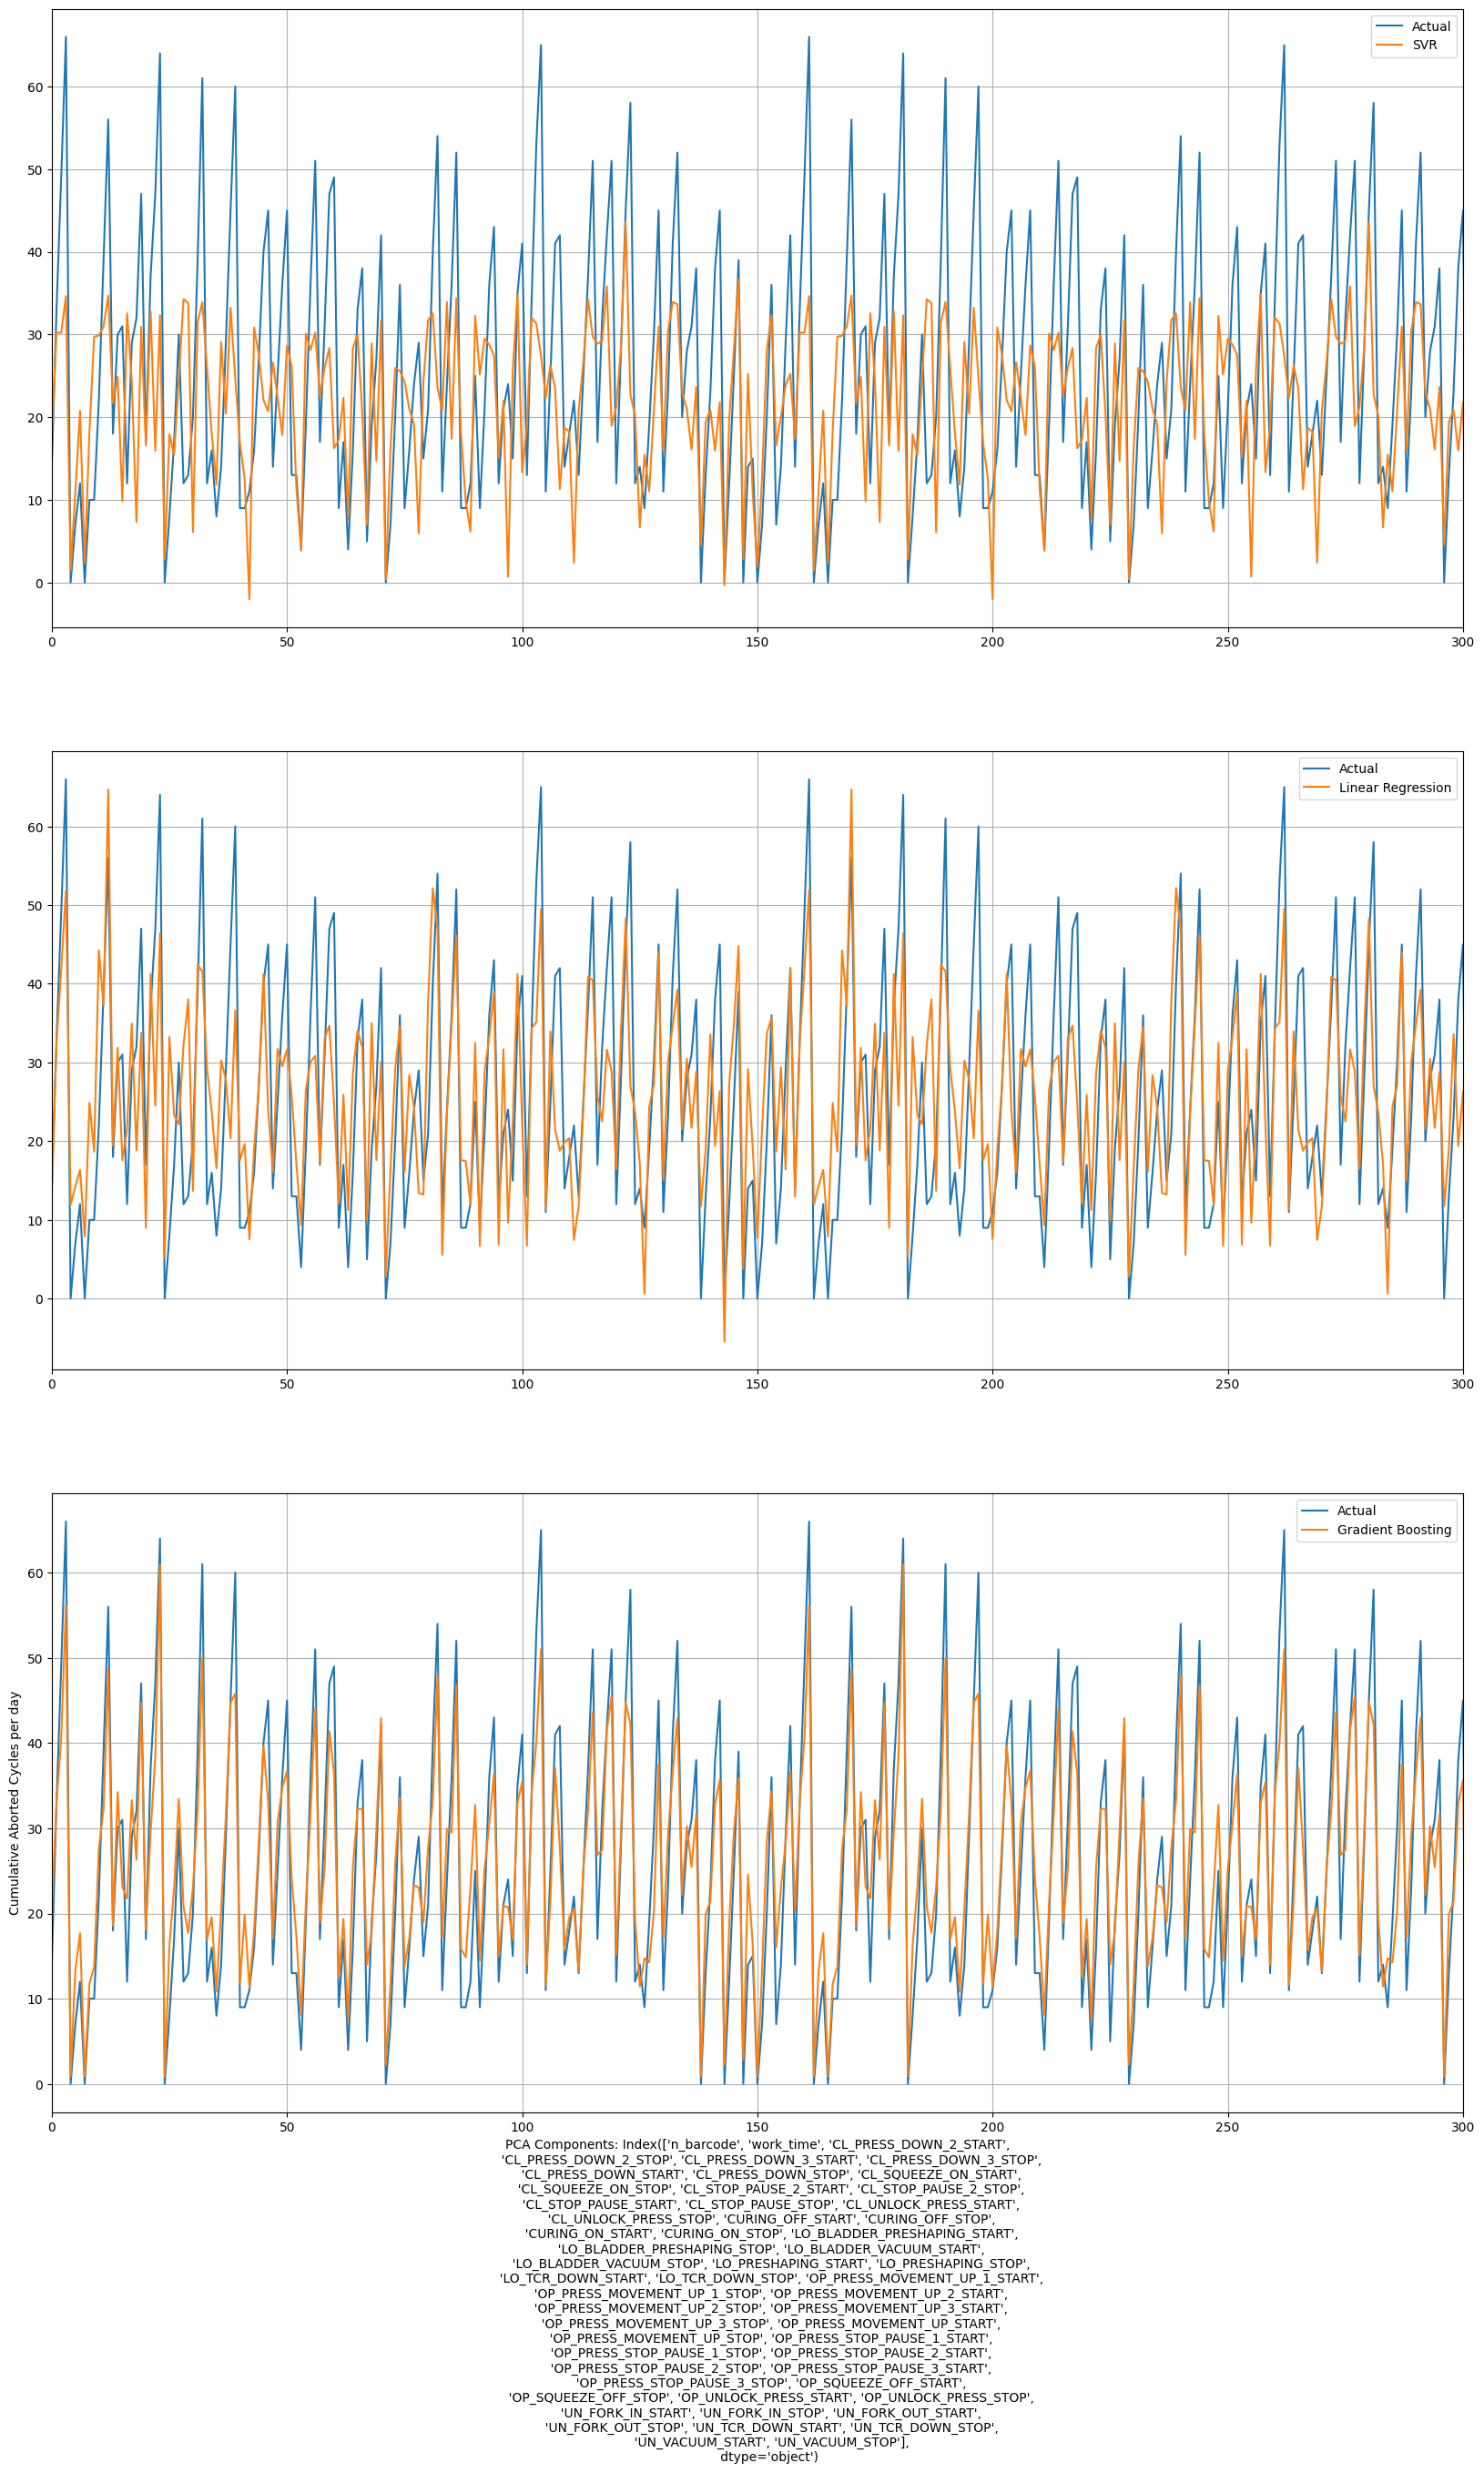

In [33]:
train_df = []
for i in range(10):
    df, current_machine = get_data(0)
    train_df.append(df)
df = pd.concat(train_df)
df.fillna(0, inplace=True)
df.drop(columns=['y-m-day-hour_3_rounded'], inplace=True)
x, x_df = linearize_input(df)
y = df['cumulative_per_day_CYCLE_ABORTED_day'].to_numpy()

# model = evaluations(x,y, log_regression, desc = "Logistic Regression")
pca = decomposition.PCA(n_components=1)
x_ = pca.fit_transform(x)

scale_x, scale_y, scaler = scale(x,y)

model_svr = evaluations(scale_x,scale_y, svr_regression, desc = "SVR")
model_lin = evaluations(scale_x,scale_y, lin_regr, desc = "Linear Regression")
model_gb = evaluations(scale_x,scale_y, grad_boost, desc = "Gradient Boosting")

figure = plt.subplots(8,9)
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ax1.plot(scale_y, label='Actual')
ax1.plot(model_svr.predict(scale_x), label='SVR')
ax1.legend()
ax1.grid()
ax1.set_xlim(0,300)
ax2.plot(scale_y, label='Actual')
ax2.plot(model_lin.predict(scale_x), label='Linear Regression')
ax2.legend()
ax2.grid()
ax2.set_xlim(0,300)
ax3.plot(scale_y, label='Actual')
ax3.plot(model_gb.predict(scale_x), label='Gradient Boosting')
ax3.legend()
ax3.grid()
ax3.set_xlim(0,300)
figure[0].set_size_inches(20,30)
plt.xlabel(f'PCA Components: {x_df.columns}')
plt.ylabel('Cumulative Aborted Cycles per day')
#plt.savefig('src/prediction/figures/evaluations_of_models_PCA_Over_COmulative_Cycle_Aborted.png')
plt.show()